In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn import preprocessing
import tensorflow as tf
from sklearn.metrics import accuracy_score
from collections import Counter
import sklearn
import csv
import pandas as pd
from datetime import datetime
from PIL import Image, ImageFilter
import json
from tensorflow.keras.callbacks import Callback
import gc

#models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

#preprocess functions
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

## Loading dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#real images
real_images = np.load('/content/drive/MyDrive/MaskDetection/real_images.npy')
real_labels = np.load('/content/drive/MyDrive/MaskDetection/real_labels.npy')

In [3]:
#real images
gen_images = np.load('/content/drive/MyDrive/MaskDetection/generated_images.npy')
gen_labels = np.load('/content/drive/MyDrive/MaskDetection/generated_labels.npy')

In [4]:
X_train = np.concatenate([real_images, gen_images])
y_train = np.concatenate([real_labels, gen_labels])

In [5]:
X_test = np.load('/content/drive/MyDrive/MaskDetection/x_test.npy')
y_test = np.load('/content/drive/MyDrive/MaskDetection/y_test.npy')

In [6]:
X_valid = np.load('/content/drive/MyDrive/MaskDetection/x_valid.npy')
y_valid = np.load('/content/drive/MyDrive/MaskDetection/y_valid.npy')

In [7]:
print(real_images.shape, X_test.shape, X_valid.shape)

(7971, 224, 224, 3) (673, 224, 224, 3) (755, 224, 224, 3)


In [7]:
del real_images
del real_labels
del gen_images
del gen_labels

## Functions

In [8]:
def make_preview(images, labels, n=25, len_per_image=2.6):
  sqrt_n = int(np.ceil(np.sqrt(n)))
  size = sqrt_n * len_per_image

  random_indices = np.random.choice(len(labels), size=n)

  plt.figure(figsize=(size, size))
  for i, idx in enumerate(random_indices):
      image = images[idx]
      label = labels[idx]
      
      plt.subplot(sqrt_n, sqrt_n, i+1)
      plt.imshow(image)
      plt.title(label)
      plt.axis('off')
  plt.show()

In [9]:
def data_split(images, labels, test_size):
  if test_size < 1:
    test_size = int(len(images) * test_size)
  
  images, labels = shuffle(images, labels)
  X_test = images[:test_size]
  y_test = labels[:test_size]
  X_train = images[test_size:]
  y_train = labels[test_size:]

  return X_train, y_train, X_test, y_test

In [10]:
def split_data(images, labels, ratio):
  assert sum(ratio) == 1
  images, labels = sklearn.utils.shuffle(images, labels, random_state=42)

  ret = []
  pos = 0
  for r in ratio:
    size = int(len(images) * r)
    s_images = images[pos:pos+size]
    s_labels = labels[pos:pos+size]
    pos += size
    ret.extend([s_images, s_labels])

  return tuple(ret)

In [11]:
def preprocess(image):
  return image / 127.5 - 1.0

In [12]:
def logger(filename, data):
  if os.path.isfile(filename):
    df = pd.read_csv(filename)
    new_df = pd.DataFrame.from_records([data])
    df = pd.concat([df, new_df], axis=0)
  else:
    df = pd.DataFrame().from_records([data])
  df.to_csv(filename, index=False)

In [13]:
def save_history(filename, history):
  df = pd.DataFrame.from_dict(data=history)
  df.to_csv(filename)

In [14]:
def save_model_json(filename, model):
  config = model.to_json()
  with open(filename, 'w') as f:
    f.write(config)

In [15]:
def create_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)

In [16]:
def classification_report(model, X_test, y_test, target_names):
  y_pred = model.predict(X_test)
  report = sklearn.metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names, output_dict=True)
  text_report = sklearn.metrics.classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=target_names)
  print(text_report)
  return report

In [17]:
def pipeline(model, train_data, valid_data, fit_params, generator, filename, directory, date, other=None):
  if directory[-1] != '/':
    directory += '/'
  
  results_path = directory+'Results_'+filename+'/'
  plots_path = results_path+'Plots_'+filename+'/'
  hist_path = results_path+'Histories_'+filename+'/'
  models_path = results_path+'Models_'+filename+'/'

  paths = [results_path, plots_path, hist_path, models_path]
  for path in paths:
    create_dir(path)

  d = dict()
  d.update({'date':date})
  d.update(fit_params)
  d.update(generator.__dict__)
  if isinstance(other, dict):
    d.update(other)
  H = model.fit(x=train_data,
                validation_data=valid_data,
                **fit_params)
  save_history(hist_path+date+'.csv', H.history)
  make_plot(plots_path+date+'.png', H)
  save_model_json(models_path+date+'.json', model)

  model.load_weights(models_path+date+'.h5')

  target_names = ['valid_'+c for c in lb.classes_]
  results = classification_report(model, X_valid_norm, y_valid, target_names=target_names)
  d.update(results)

  target_names = ['test_'+c for c in lb.classes_]
  results = classification_report(model, X_test_norm, y_test, target_names=target_names)
  d.update(results)

  filename = results_path+filename+'.csv'
  logger(filename, d)

  return H

In [18]:
def make_plot(filename, H):
  from datetime import datetime
  plt.figure()
  keys = list(H.history.keys())
  for key in keys: 
    plt.plot(H.history[key])
    plt.ylabel('value')
    plt.xlabel('epoch')
  plt.legend(keys)
  plt.savefig(filename)
  plt.show()

In [19]:
def accuracy(model, X_test, y_test, class_name=None):
  if class_name:
    labels = lb.inverse_transform(y_test)
    indices = np.where(labels == class_name)[0]
    X_test = X_test[indices]
    y_test = y_test[indices]
  test_preds = model.predict(X_test)
  m = tf.keras.metrics.CategoricalAccuracy()
  m.update_state(y_test, test_preds)
  return round(m.result().numpy(),4)

In [20]:
class MetricsCallback(Callback):
    def __init__(self, test_data, y_true, directory, filename, date):
        # Should be the label encoding of your classes
        self.y_true = y_true
        self.test_data = test_data
        self.date = date
        self.best_result = 0
        if directory[-1] != '/':
          directory += '/'
        self.results_path = directory+'Results_'+filename+'/'
        self.callbacks_path = self.results_path+'Callbacks_'+filename+'/'
        self.models_path = self.results_path+'Models_'+filename+'/'
        paths = [self.results_path, self.callbacks_path, self.models_path]
        for path in paths:
          create_dir(path)
        
    def on_epoch_end(self, epoch, logs=None):
        # Here we get the probabilities
        y_pred = self.model.predict(self.test_data)
        # Here we get the actual classes
        y_pred = tf.argmax(y_pred,axis=1)
        # Actual dictionary
        report_dictionary = classification_report(self.model, self.test_data, self.y_true, lb.classes_)

        mean_f1_score = 0
        for c in lb.classes_:
          mean_f1_score += report_dictionary[c]['f1-score']
        mean_f1_score /= len(lb.classes_)
        if mean_f1_score > self.best_result:
          self.best_result = mean_f1_score
          self.model.save_weights(self.models_path+self.date+'.h5')
          print('Model saved\n')
        logger(self.callbacks_path+self.date+'.csv', report_dictionary)

In [21]:
class CombinedGen():
    def __init__(self, x, y, batch_size, ratio):
        self.batch_size=batch_size
        self.x=x
        self.y=y
        self.ratio=ratio
        sizes = [int(round(r*batch_size, 0)) for r in ratio]
        assert sum(sizes) == batch_size 
        self.train_gens = self.combine_generators(x, y, sizes)
        self.train_gen = self.init_generators(self.train_gens)

    def combine_generators(self, x, y, sizes):
      train_gens = []

      for c, s in zip(lb.classes_, sizes):
        indices = np.where(lb.inverse_transform(y) == c)[0]
        xc = x[indices]
        yc = y[indices]

        t_gen = gen.flow(
        x=xc,
        y=yc,
        batch_size=s,
        seed=42,
        shuffle=True)

        train_gens.append(t_gen)

      return train_gens

    def init_generators(self, generators):
      while True:
        images = []
        labels = []
        for g in generators:
          img, lab = g.next()
          images.append(img)
          labels.append(lab)
        
        images = np.concatenate(images, axis=0)
        labels = np.concatenate(labels, axis=0)
        images, labels = sklearn.utils.shuffle(images, labels)
        yield (images, labels)
    
    def reset_generators(self):
      for g in self.train_gens:
        g.reset()
      self.train_gen = self.init_generators(self.train_gens)

    def generate_train(self):
      return self.train_gen

    def train_len(self):
      return len(self.x)//batch_size

In [ ]:
make_preview(real_images, real_labels)

NameError: ignored

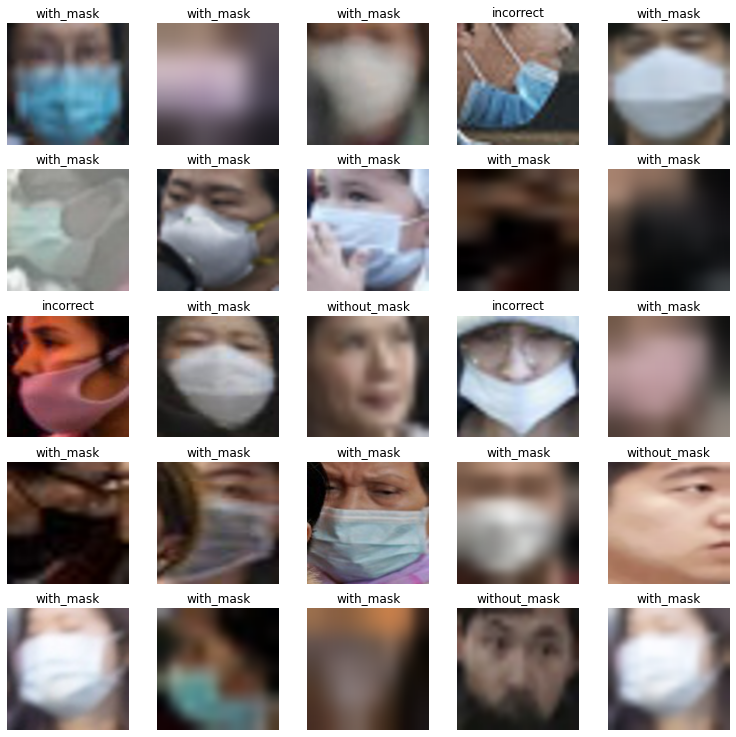

In [ ]:
make_preview(X_test, y_test)

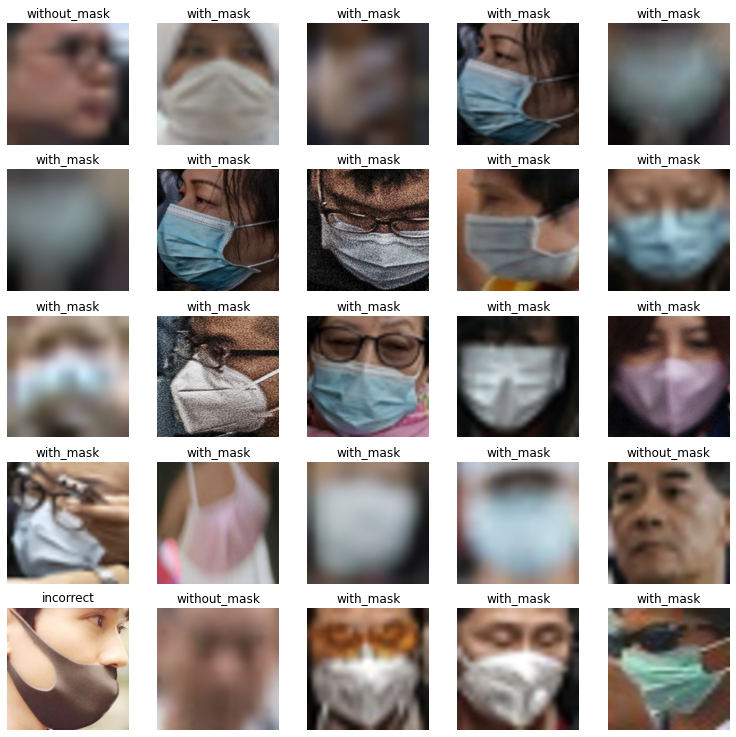

In [ ]:
make_preview(X_valid, y_valid)

## Normalizing validation and test set

In [22]:
X_valid_norm = X_valid / 127.5 - 1.0
X_valid_norm = X_valid_norm.astype(np.float32, copy=False)

X_test_norm = X_test / 127.5 - 1.0
X_test_norm = X_test_norm.astype(np.float32, copy=False)

del X_valid
del X_test

## Encoding labels

In [23]:
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_valid = lb.transform(y_valid)
y_test = lb.transform(y_test)

In [24]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

## Data Generator

In [ ]:
lb.classes_

array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12')

In [25]:
# do pogorszenia jakości zdjęć
def preprocess(image):
  image = image.astype(np.uint8)
  im = Image.fromarray(image)
  if np.random.binomial(1,0.5):
    s = np.random.randint(20, 101, 1)[0]
    im = im.resize((s,s))
    im = im.resize((224, 224))
  if np.random.binomial(1,0.5):
    radius = np.random.randint(0, 10, 1)[0]
    im = im.filter(ImageFilter.GaussianBlur(radius=radius))
  im = np.array(im)
  return (im/127.5 - 1.0).astype(np.float32)

In [26]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess,
    rotation_range=20,
	  zoom_range=0.15,
	  width_shift_range=0.15,
	  height_shift_range=0.15,
	  shear_range=0.15,
	  horizontal_flip=True,
	  fill_mode="nearest")

In [27]:
init_lr = 1e-4
epochs = 5
batch_size = 32
input_shape = (224, 224,3)
directory = '/content/drive/MyDrive/MaskDetection'
filename = '16_05_2021'

In [ ]:
train_gen = gen.flow(
x=real_images,
y=y_train,
batch_size=batch_size,
seed=42,
shuffle=True)

#MobileNetV2

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/mobilenet_init_weights_16_05_2021.h5')

In [ ]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/mobilenet_init_weights_06_05_2021.h5')

Epoch 1/5
250/250 [==============================] - 118s 336ms/step - loss: 0.6770 - acc: 0.7395 - val_loss: 0.6457 - val_acc: 0.8053
              precision    recall  f1-score   support

   incorrect       0.75      0.03      0.06        97
   with_mask       0.84      0.94      0.89       525
without_mask       0.68      0.83      0.75       133

    accuracy                           0.81       755
   macro avg       0.76      0.60      0.57       755
weighted avg       0.80      0.81      0.76       755

Model saved

Epoch 2/5
250/250 [==============================] - 83s 333ms/step - loss: 0.3061 - acc: 0.8830 - val_loss: 0.5754 - val_acc: 0.8185
              precision    recall  f1-score   support

   incorrect       0.88      0.07      0.13        97
   with_mask       0.85      0.94      0.89       525
without_mask       0.71      0.86      0.78       133

    accuracy                           0.82       755
   macro avg       0.81      0.63      0.60       755
weighted av

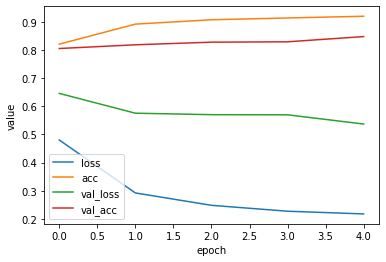

                    precision    recall  f1-score   support

   valid_incorrect       0.91      0.22      0.35        97
   valid_with_mask       0.86      0.97      0.91       525
valid_without_mask       0.80      0.84      0.82       133

          accuracy                           0.85       755
         macro avg       0.86      0.67      0.69       755
      weighted avg       0.85      0.85      0.82       755

                   precision    recall  f1-score   support

   test_incorrect       0.94      0.16      0.27       103
   test_with_mask       0.80      0.98      0.88       452
test_without_mask       0.76      0.67      0.71       118

         accuracy                           0.80       673
        macro avg       0.83      0.60      0.62       673
     weighted avg       0.82      0.80      0.76       673



In [ ]:
fit_params = dict(steps_per_epoch=len(train_gen),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='MobileNetV2, only head unfreezed, only real images, 5 epochs')
H = pipeline(model, train_gen, (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f67215b4f90>: False
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721c1c250>: False
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6720574950>: False
3. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6720574dd0>: False
4. <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f6721ab6490>: False
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa74d0>: False
6. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f672308d850>: False
7. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721aa7f90>: False
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa7810>: False
9. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721e6c350>: False
10. <tensorflow.python.keras.layers.normaliz

In [ ]:
for layer in baseModel.layers[149:]:
	layer.trainable = True

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f67215b4f90>: False
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721c1c250>: False
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6720574950>: False
3. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6720574dd0>: False
4. <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f6721ab6490>: False
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa74d0>: False
6. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f672308d850>: False
7. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721aa7f90>: False
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa7810>: False
9. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721e6c350>: False
10. <tensorflow.python.keras.layers.normaliz

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
train_gen.reset()

Epoch 1/5
250/250 [==============================] - 85s 331ms/step - loss: 0.2493 - acc: 0.9072 - val_loss: 1.4312 - val_acc: 0.8000
              precision    recall  f1-score   support

   incorrect       1.00      0.05      0.10        97
   with_mask       0.79      1.00      0.88       525
without_mask       0.85      0.56      0.68       133

    accuracy                           0.80       755
   macro avg       0.88      0.54      0.55       755
weighted avg       0.83      0.80      0.75       755

Model saved

Epoch 2/5
250/250 [==============================] - 82s 327ms/step - loss: 0.1875 - acc: 0.9303 - val_loss: 1.6689 - val_acc: 0.7788
              precision    recall  f1-score   support

   incorrect       1.00      0.10      0.19        97
   with_mask       0.77      1.00      0.87       525
without_mask       0.83      0.40      0.54       133

    accuracy                           0.78       755
   macro avg       0.87      0.50      0.53       755
weighted avg

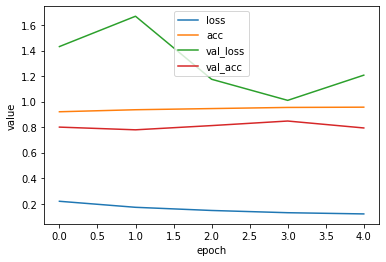

                    precision    recall  f1-score   support

   valid_incorrect       1.00      0.12      0.22        97
   valid_with_mask       0.84      0.99      0.91       525
valid_without_mask       0.85      0.80      0.82       133

          accuracy                           0.85       755
         macro avg       0.90      0.64      0.65       755
      weighted avg       0.87      0.85      0.81       755

                   precision    recall  f1-score   support

   test_incorrect       1.00      0.09      0.16       103
   test_with_mask       0.79      0.99      0.88       452
test_without_mask       0.80      0.67      0.73       118

         accuracy                           0.80       673
        macro avg       0.86      0.58      0.59       673
     weighted avg       0.83      0.80      0.74       673



In [ ]:
fit_params = dict(steps_per_epoch=len(train_gen),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='MobileNetV2, layers unfreezed from 149, only real images, 5 epochs')
H = pipeline(model, train_gen, (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

# MobileNetV2 with weight balancing

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
#reset model - load init weights
model.load_weights('/content/drive/MyDrive/MaskDetection/mobilenet_init_weights_16_05_2021.h5')

In [ ]:
train_gen.reset()

In [ ]:
class_weight = sklearn.utils.class_weight.compute_class_weight('balanced',
                                                               np.unique(np.argmax(y_train, axis=1)),
                                                               np.argmax(y_train, axis=1))
class_weight = {i:class_weight[i] for i in range(len(class_weight))}
class_weight

{0: 8.303125, 1: 0.4489692463670159, 2: 1.5331794575879978}

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

Epoch 1/5
250/250 [==============================] - 83s 323ms/step - loss: 0.9339 - acc: 0.5886 - val_loss: 0.6071 - val_acc: 0.7589
              precision    recall  f1-score   support

   incorrect       0.64      0.33      0.44        97
   with_mask       0.88      0.81      0.84       525
without_mask       0.52      0.88      0.65       133

    accuracy                           0.76       755
   macro avg       0.68      0.67      0.64       755
weighted avg       0.79      0.76      0.76       755

Model saved

Epoch 2/5
250/250 [==============================] - 81s 324ms/step - loss: 0.5445 - acc: 0.7879 - val_loss: 0.5466 - val_acc: 0.8013
              precision    recall  f1-score   support

   incorrect       0.54      0.46      0.50        97
   with_mask       0.91      0.84      0.87       525
without_mask       0.63      0.90      0.75       133

    accuracy                           0.80       755
   macro avg       0.70      0.73      0.71       755
weighted avg

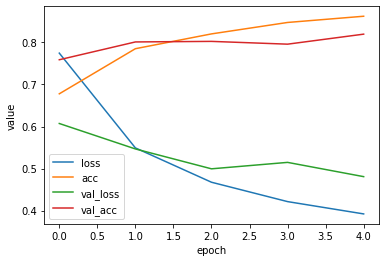

                    precision    recall  f1-score   support

   valid_incorrect       0.65      0.43      0.52        97
   valid_with_mask       0.91      0.86      0.89       525
valid_without_mask       0.64      0.92      0.76       133

          accuracy                           0.82       755
         macro avg       0.73      0.74      0.72       755
      weighted avg       0.83      0.82      0.82       755

                   precision    recall  f1-score   support

   test_incorrect       0.75      0.43      0.54       103
   test_with_mask       0.88      0.84      0.86       452
test_without_mask       0.58      0.89      0.70       118

         accuracy                           0.78       673
        macro avg       0.73      0.72      0.70       673
     weighted avg       0.80      0.78      0.78       673



In [ ]:
fit_params = dict(steps_per_epoch=len(train_gen),
                  epochs=epochs,
                  callbacks=[metrics_callback],
                  class_weight=class_weight)
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='MobileNetV2, only head unfreezed, only real images, 5 epochs, weight balancing')
H = pipeline(model, train_gen, (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

# Unfreeze some layers

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f67215b4f90>: False
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721c1c250>: False
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6720574950>: False
3. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6720574dd0>: False
4. <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f6721ab6490>: False
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa74d0>: False
6. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f672308d850>: False
7. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721aa7f90>: False
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa7810>: False
9. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721e6c350>: False
10. <tensorflow.python.keras.layers.normaliz

In [ ]:
for layer in baseModel.layers[149:]:
	layer.trainable = True

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f67215b4f90>: False
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721c1c250>: False
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6720574950>: False
3. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6720574dd0>: False
4. <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f6721ab6490>: False
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa74d0>: False
6. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f672308d850>: False
7. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721aa7f90>: False
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6721aa7810>: False
9. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6721e6c350>: False
10. <tensorflow.python.keras.layers.normaliz

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
train_gen.reset()

Epoch 1/5
250/250 [==============================] - 84s 327ms/step - loss: 0.4428 - acc: 0.8491 - val_loss: 0.8482 - val_acc: 0.8318
              precision    recall  f1-score   support

   incorrect       1.00      0.07      0.13        97
   with_mask       0.84      0.97      0.90       525
without_mask       0.78      0.84      0.81       133

    accuracy                           0.83       755
   macro avg       0.87      0.63      0.62       755
weighted avg       0.85      0.83      0.79       755

Model saved

Epoch 2/5
250/250 [==============================] - 81s 324ms/step - loss: 0.3059 - acc: 0.8849 - val_loss: 0.7972 - val_acc: 0.8106
              precision    recall  f1-score   support

   incorrect       0.86      0.26      0.40        97
   with_mask       0.79      1.00      0.88       525
without_mask       0.97      0.48      0.64       133

    accuracy                           0.81       755
   macro avg       0.87      0.58      0.64       755
weighted avg

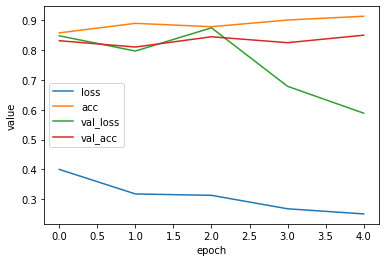

                    precision    recall  f1-score   support

   valid_incorrect       0.85      0.30      0.44        97
   valid_with_mask       0.89      0.94      0.91       525
valid_without_mask       0.72      0.92      0.81       133

          accuracy                           0.85       755
         macro avg       0.82      0.72      0.72       755
      weighted avg       0.86      0.85      0.83       755

                   precision    recall  f1-score   support

   test_incorrect       0.93      0.27      0.42       103
   test_with_mask       0.86      0.88      0.87       452
test_without_mask       0.62      0.94      0.75       118

         accuracy                           0.80       673
        macro avg       0.81      0.70      0.68       673
     weighted avg       0.83      0.80      0.78       673



In [ ]:
fit_params = dict(steps_per_epoch=len(train_gen),
                  epochs=epochs,
                  callbacks=[metrics_callback],
                  class_weight=class_weight)
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='MobileNetV2, layers unfreezed from 149, only real images, 5 epochs, weight balancing')
H = pipeline(model, train_gen, (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

#MobileNetV2 with oversampling

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

In [ ]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = True

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/mobilenet_init_weights_07_05_2021.h5')

In [ ]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/mobilenet_init_weights_16_05_2021.h5')

In [ ]:
del cg
gc.collect()

6066

In [ ]:
lb.classes_

array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12')

In [ ]:
ratios = [0.33, 0.32, 0.33]
cg = CombinedGen(X_train, y_train, 32, ratios)

In [ ]:
cg.reset_generators()

Epoch 1/5
341/341 [==============================] - 202s 487ms/step - loss: 0.5262 - acc: 0.7723 - val_loss: 0.3972 - val_acc: 0.8848
              precision    recall  f1-score   support

   incorrect       0.89      0.34      0.49        97
   with_mask       0.92      0.96      0.94       525
without_mask       0.78      0.98      0.87       133

    accuracy                           0.88       755
   macro avg       0.86      0.76      0.77       755
weighted avg       0.89      0.88      0.87       755

Model saved

Epoch 2/5
341/341 [==============================] - 164s 482ms/step - loss: 0.1437 - acc: 0.9512 - val_loss: 0.6305 - val_acc: 0.8702
              precision    recall  f1-score   support

   incorrect       0.90      0.58      0.70        97
   with_mask       0.96      0.89      0.93       525
without_mask       0.64      1.00      0.78       133

    accuracy                           0.87       755
   macro avg       0.84      0.82      0.80       755
weighted a

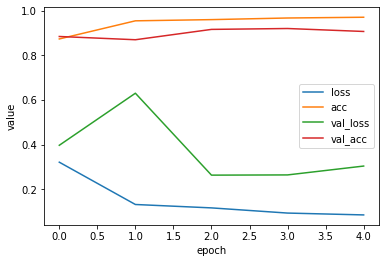

                    precision    recall  f1-score   support

   valid_incorrect       0.85      0.65      0.74        97
   valid_with_mask       0.97      0.93      0.95       525
valid_without_mask       0.75      0.99      0.85       133

          accuracy                           0.91       755
         macro avg       0.86      0.86      0.85       755
      weighted avg       0.92      0.91      0.91       755

                   precision    recall  f1-score   support

   test_incorrect       0.90      0.62      0.74       103
   test_with_mask       0.96      0.90      0.93       452
test_without_mask       0.66      0.99      0.80       118

         accuracy                           0.87       673
        macro avg       0.84      0.84      0.82       673
     weighted avg       0.90      0.87      0.87       673



In [ ]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             ratios=ratios,
             description='MobileNetV2, all layers unfreezed, real and generated images, with oversampling, 5 epochs, with blur and resizing')
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

##Unfreeze some layers

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

In [ ]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
#2021_05_16_19_30_00
model.load_weights('/content/drive/MyDrive/MaskDetection/Results_16_05_2021/Models_16_05_2021/2021_05_16_19_30_00.h5')

In [ ]:
lb.classes_

array(['incorrect', 'with_mask', 'without_mask'], dtype='<U12')

In [ ]:
for layer in baseModel.layers:
	layer.trainable = True

In [ ]:
for layer in baseModel.layers[149:]:
	layer.trainable = True

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f6eb7c9ab10>: True
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6eb77f9750>: True
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6eb9095050>: True
3. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6eb7ce4750>: True
4. <tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7f6eb7cdc790>: True
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6eb7e9f110>: True
6. <tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x7f6eb7823dd0>: True
7. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6eb7d33110>: True
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f6eb7cbc090>: True
9. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6eb80eec90>: True
10. <tensorflow.python.keras.layers.normalization_v2.B

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
ratios = [0.33, 0.32, 0.33]
cg = CombinedGen(real_images, y_train, 32, ratios)

In [ ]:
cg.reset_generators()

Epoch 1/5
249/249 [==============================] - 136s 409ms/step - loss: 0.4390 - acc: 0.8270 - val_loss: 0.4669 - val_acc: 0.8954
              precision    recall  f1-score   support

   incorrect       0.91      0.40      0.56        97
   with_mask       0.89      0.98      0.94       525
without_mask       0.91      0.90      0.91       133

    accuracy                           0.90       755
   macro avg       0.90      0.76      0.80       755
weighted avg       0.90      0.90      0.88       755

Model saved

Epoch 2/5
249/249 [==============================] - 99s 398ms/step - loss: 0.1102 - acc: 0.9629 - val_loss: 0.4722 - val_acc: 0.8848
              precision    recall  f1-score   support

   incorrect       0.88      0.39      0.54        97
   with_mask       0.89      0.98      0.93       525
without_mask       0.87      0.87      0.87       133

    accuracy                           0.88       755
   macro avg       0.88      0.75      0.78       755
weighted av

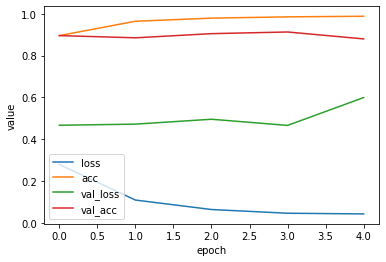

                    precision    recall  f1-score   support

   valid_incorrect       0.90      0.54      0.67        97
   valid_with_mask       0.92      0.98      0.95       525
valid_without_mask       0.88      0.92      0.90       133

          accuracy                           0.91       755
         macro avg       0.90      0.81      0.84       755
      weighted avg       0.91      0.91      0.91       755

                   precision    recall  f1-score   support

   test_incorrect       0.89      0.47      0.61       103
   test_with_mask       0.88      0.97      0.92       452
test_without_mask       0.84      0.86      0.85       118

         accuracy                           0.87       673
        macro avg       0.87      0.77      0.80       673
     weighted avg       0.87      0.87      0.86       673



In [ ]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             ratios=ratios,
             description='MobileNetV2, all layers unfreezed (train pretrained model 2021_05_16_19_30_00), only real images, with oversampling, 5 epochs')
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

#Xception

In [28]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [29]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [30]:
baseModel = Xception(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

In [31]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [32]:
for layer in baseModel.layers:
	layer.trainable = True

In [33]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/xception_init_weights_16_05_2021.h5')

In [35]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/xception_init_weights_16_05_2021.h5')

In [34]:
#2021_05_16_22_50_06
model.load_weights('/content/drive/MyDrive/MaskDetection/Results_16_05_2021/Models_16_05_2021/2021_05_16_22_50_06.h5')

In [35]:
ratios = [0.33, 0.32, 0.35]
cg = CombinedGen(X_train, y_train, 32, ratios)

In [38]:
cg.reset_generators()

In [36]:
epochs = 1

341/341 [==============================] - 501s 1s/step - loss: 0.0242 - acc: 0.9929 - val_loss: 0.3287 - val_acc: 0.9311
              precision    recall  f1-score   support

   incorrect       0.87      0.68      0.76        97
   with_mask       0.96      0.97      0.97       525
without_mask       0.85      0.97      0.91       133

    accuracy                           0.93       755
   macro avg       0.89      0.87      0.88       755
weighted avg       0.93      0.93      0.93       755

Model saved



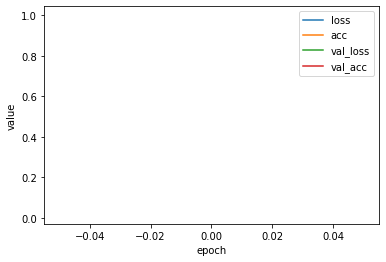

                    precision    recall  f1-score   support

   valid_incorrect       0.87      0.68      0.76        97
   valid_with_mask       0.96      0.97      0.97       525
valid_without_mask       0.85      0.97      0.91       133

          accuracy                           0.93       755
         macro avg       0.89      0.87      0.88       755
      weighted avg       0.93      0.93      0.93       755

                   precision    recall  f1-score   support

   test_incorrect       0.92      0.71      0.80       103
   test_with_mask       0.96      0.98      0.97       452
test_without_mask       0.86      0.97      0.91       118

         accuracy                           0.94       673
        macro avg       0.92      0.89      0.90       673
     weighted avg       0.94      0.94      0.94       673



In [37]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='Xception, all layers unfreezed (train pretrained model 2021_05_16_22_50_06 - more without mask), real and generated images, 1 epoch, with blur and resizing',
             ratios=ratios)
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

#Xception - unfreeze some layers

In [ ]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [ ]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd441508e10>: False
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd3fa3a0890>: False
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd3f9eab750>: False
3. <tensorflow.python.keras.layers.core.Activation object at 0x7fd3f9d4ccd0>: False
4. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd3f053b190>: False
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd3f0540fd0>: False
6. <tensorflow.python.keras.layers.core.Activation object at 0x7fd3f054a990>: False
7. <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7fd3f053ced0>: False
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd3f0551f10>: False
9. <tensorflow.python.keras.layers.core.Activation object at 0x7fd3f0540cd0>: False
10. <tensorflow.python.keras.layers.convolutional.SeparableConv2D obj

In [ ]:
for layer in baseModel.layers[126:]:
	layer.trainable = True

In [ ]:
for i,layer in enumerate(baseModel.layers):
	print("{}. {}: {}".format(i, layer, layer.trainable))

0. <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fd441508e10>: False
1. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd3fa3a0890>: False
2. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd3f9eab750>: False
3. <tensorflow.python.keras.layers.core.Activation object at 0x7fd3f9d4ccd0>: False
4. <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fd3f053b190>: False
5. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd3f0540fd0>: False
6. <tensorflow.python.keras.layers.core.Activation object at 0x7fd3f054a990>: False
7. <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7fd3f053ced0>: False
8. <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fd3f0551f10>: False
9. <tensorflow.python.keras.layers.core.Activation object at 0x7fd3f0540cd0>: False
10. <tensorflow.python.keras.layers.convolutional.SeparableConv2D obj

In [ ]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [ ]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/mobilenetv2_init_weights_22_04_2021.h5')

In [ ]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/mobilenetv2_init_weights_22_04_2021.h5')

In [ ]:
cg.reset_generators()

Epoch 1/5
341/341 [==============================] - 207s 596ms/step - loss: 0.2349 - acc: 0.9180 - val_loss: 0.3072 - val_acc: 0.8848
              precision    recall  f1-score   support

   incorrect       0.70      0.60      0.64        97
   with_mask       0.94      0.93      0.93       525
without_mask       0.81      0.92      0.86       133

    accuracy                           0.88       755
   macro avg       0.81      0.82      0.81       755
weighted avg       0.88      0.88      0.88       755

Model saved

Epoch 2/5
341/341 [==============================] - 204s 598ms/step - loss: 0.1619 - acc: 0.9428 - val_loss: 0.2656 - val_acc: 0.9086
              precision    recall  f1-score   support

   incorrect       0.84      0.58      0.68        97
   with_mask       0.92      0.97      0.94       525
without_mask       0.90      0.91      0.90       133

    accuracy                           0.91       755
   macro avg       0.88      0.82      0.84       755
weighted a

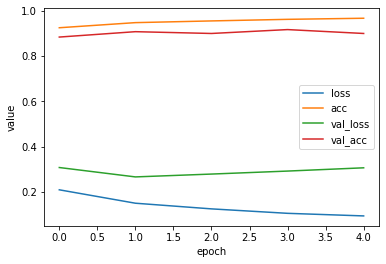

                    precision    recall  f1-score   support

   valid_incorrect       0.85      0.64      0.73        97
   valid_with_mask       0.94      0.96      0.95       525
valid_without_mask       0.86      0.95      0.90       133

          accuracy                           0.92       755
         macro avg       0.88      0.85      0.86       755
      weighted avg       0.92      0.92      0.91       755

                   precision    recall  f1-score   support

   test_incorrect       0.89      0.69      0.78       103
   test_with_mask       0.95      0.96      0.96       452
test_without_mask       0.82      0.95      0.88       118

         accuracy                           0.92       673
        macro avg       0.89      0.87      0.87       673
     weighted avg       0.92      0.92      0.92       673



In [ ]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='Xception, layers unfreezed from 126, real and generated images, 5 epochs')
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

#VGG16

In [28]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [29]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [32]:
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

In [33]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [34]:
for layer in baseModel.layers:
	layer.trainable = True

In [35]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [36]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/vgg16_init_weights_16_05_2021.h5')

In [ ]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/xception_init_weights_16_05_2021.h5')

In [ ]:
#2021_05_16_22_50_06
model.load_weights('/content/drive/MyDrive/MaskDetection/Results_16_05_2021/Models_16_05_2021/2021_05_16_22_50_06.h5')

In [37]:
ratios = [0.3, 0.35, 0.35]
cg = CombinedGen(X_train, y_train, 32, ratios)

In [ ]:
cg.reset_generators()

Epoch 1/5
341/341 [==============================] - 344s 882ms/step - loss: 0.5074 - acc: 0.8049 - val_loss: 0.2020 - val_acc: 0.9232
              precision    recall  f1-score   support

   incorrect       0.78      0.73      0.76        97
   with_mask       0.97      0.95      0.96       525
without_mask       0.85      0.97      0.91       133

    accuracy                           0.92       755
   macro avg       0.87      0.88      0.87       755
weighted avg       0.92      0.92      0.92       755

Model saved

Epoch 2/5
341/341 [==============================] - 282s 826ms/step - loss: 0.2035 - acc: 0.9338 - val_loss: 0.2169 - val_acc: 0.9126
              precision    recall  f1-score   support

   incorrect       0.83      0.55      0.66        97
   with_mask       0.93      0.98      0.95       525
without_mask       0.89      0.92      0.91       133

    accuracy                           0.91       755
   macro avg       0.88      0.82      0.84       755
weighted a

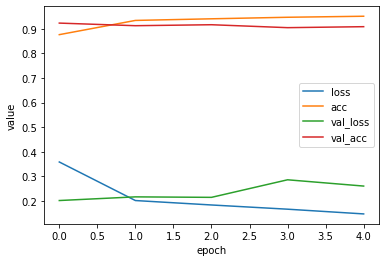

                    precision    recall  f1-score   support

   valid_incorrect       0.78      0.73      0.76        97
   valid_with_mask       0.97      0.95      0.96       525
valid_without_mask       0.85      0.97      0.91       133

          accuracy                           0.92       755
         macro avg       0.87      0.88      0.87       755
      weighted avg       0.92      0.92      0.92       755

                   precision    recall  f1-score   support

   test_incorrect       0.82      0.68      0.74       103
   test_with_mask       0.96      0.95      0.96       452
test_without_mask       0.78      0.92      0.85       118

         accuracy                           0.91       673
        macro avg       0.86      0.85      0.85       673
     weighted avg       0.91      0.91      0.91       673



In [38]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='VGG16, all layers unfreezed, real and generated images, 5 epochs, with blur and resizing',
             ratios=ratios)
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

# VGG19

In [39]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [40]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [43]:
baseModel = VGG19(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

In [44]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [45]:
for layer in baseModel.layers:
	layer.trainable = True

In [46]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [47]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/vgg19_init_weights_16_05_2021.h5')

In [ ]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/xception_init_weights_16_05_2021.h5')

In [ ]:
#2021_05_16_22_50_06
model.load_weights('/content/drive/MyDrive/MaskDetection/Results_16_05_2021/Models_16_05_2021/2021_05_16_22_50_06.h5')

In [ ]:
ratios = [0.3, 0.35, 0.35]
cg = CombinedGen(X_train, y_train, 32, ratios)

In [48]:
cg.reset_generators()

Epoch 1/5
341/341 [==============================] - 333s 973ms/step - loss: 0.6120 - acc: 0.7500 - val_loss: 0.3122 - val_acc: 0.8834
              precision    recall  f1-score   support

   incorrect       0.65      0.64      0.64        97
   with_mask       0.96      0.91      0.94       525
without_mask       0.78      0.96      0.86       133

    accuracy                           0.88       755
   macro avg       0.80      0.84      0.81       755
weighted avg       0.89      0.88      0.88       755

Model saved

Epoch 2/5
341/341 [==============================] - 331s 972ms/step - loss: 0.2516 - acc: 0.9198 - val_loss: 0.2497 - val_acc: 0.8901
              precision    recall  f1-score   support

   incorrect       0.88      0.31      0.46        97
   with_mask       0.90      0.98      0.94       525
without_mask       0.84      0.94      0.89       133

    accuracy                           0.89       755
   macro avg       0.88      0.74      0.76       755
weighted a

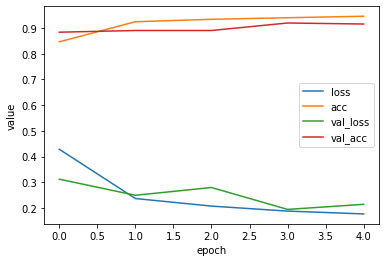

                    precision    recall  f1-score   support

   valid_incorrect       0.72      0.80      0.76        97
   valid_with_mask       0.97      0.93      0.95       525
valid_without_mask       0.89      0.95      0.92       133

          accuracy                           0.92       755
         macro avg       0.86      0.89      0.88       755
      weighted avg       0.92      0.92      0.92       755

                   precision    recall  f1-score   support

   test_incorrect       0.80      0.79      0.79       103
   test_with_mask       0.96      0.94      0.95       452
test_without_mask       0.84      0.94      0.89       118

         accuracy                           0.91       673
        macro avg       0.87      0.89      0.88       673
     weighted avg       0.92      0.91      0.91       673



In [49]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='VGG19, all layers unfreezed, real and generated images, 5 epochs, with blur and resizing',
             ratios=ratios)
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

# InceptionV3

In [50]:
date = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

In [51]:
metrics_callback = MetricsCallback(X_valid_norm, y_valid, directory, filename, date)

In [54]:
baseModel = InceptionV3(weights="imagenet", include_top=False,
	input_tensor= tf.keras.layers.Input(shape=input_shape))
headModel = baseModel.output
headModel =  tf.keras.layers.AveragePooling2D(pool_size=(5, 5))(headModel)
headModel =  tf.keras.layers.Flatten(name="flatten")(headModel)
headModel =  tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel =  tf.keras.layers.Dropout(0.5)(headModel)
headModel =  tf.keras.layers.Dense(3, activation="softmax")(headModel)

In [55]:
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

In [57]:
for layer in baseModel.layers:
	layer.trainable = True

In [58]:
opt = tf.keras.optimizers.Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["acc"])

In [59]:
#save init weights
model.save_weights('/content/drive/MyDrive/MaskDetection/inceptionv3_init_weights_16_05_2021.h5')

In [ ]:
#reset model
model.load_weights('/content/drive/MyDrive/MaskDetection/xception_init_weights_16_05_2021.h5')

In [ ]:
#2021_05_16_22_50_06
model.load_weights('/content/drive/MyDrive/MaskDetection/Results_16_05_2021/Models_16_05_2021/2021_05_16_22_50_06.h5')

In [ ]:
ratios = [0.3, 0.35, 0.35]
cg = CombinedGen(X_train, y_train, 32, ratios)

In [60]:
cg.reset_generators()

In [ ]:
fit_params = dict(steps_per_epoch=cg.train_len(),
                  epochs=epochs,
                  callbacks=[metrics_callback])
other = dict(batch_size=batch_size,
             init_lr=init_lr,
             decay=init_lr/epochs,
             description='InceptionV3, all layers unfreezed, real and generated images, 5 epochs, with blur and resizing',
             ratios=ratios)
H = pipeline(model, cg.generate_train(), (X_valid_norm, y_valid), fit_params, gen, filename, directory, date, other)

Epoch 1/5
341/341 [==============================] - 262s 735ms/step - loss: 0.4583 - acc: 0.8162 - val_loss: 0.2799 - val_acc: 0.9020
              precision    recall  f1-score   support

   incorrect       0.85      0.58      0.69        97
   with_mask       0.92      0.97      0.95       525
without_mask       0.85      0.86      0.86       133

    accuracy                           0.90       755
   macro avg       0.87      0.80      0.83       755
weighted avg       0.90      0.90      0.90       755

Model saved

Epoch 2/5
341/341 [==============================] - 243s 714ms/step - loss: 0.1399 - acc: 0.9525 - val_loss: 0.2449 - val_acc: 0.9205
              precision    recall  f1-score   support

   incorrect       0.80      0.67      0.73        97
   with_mask       0.97      0.95      0.96       525
without_mask       0.82      0.98      0.89       133

    accuracy                           0.92       755
   macro avg       0.86      0.87      0.86       755
weighted a